In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
from lsst.sims.utils import uniformSphere


In [2]:
# XXX-- a very simple placeholder function. Replace with something more realistic.
def blazar_lc(mjd, filternames):
    """A function that returns Rubin magnitudes given a date and filter
    """
    period = 100.
    
    result = mjd*0 + 17.
    phase = mjd % period
    result[np.where(phase > 90)] -= 3
    
    return result
    

(17.0, 13.5)

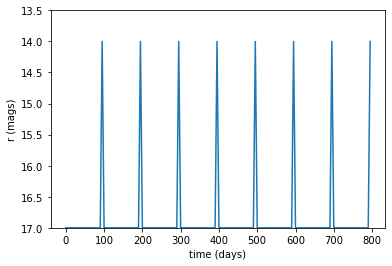

In [3]:
mjd = np.arange(0,800, 5)
plt.plot(mjd, blazar_lc(mjd, 'r'))
plt.xlabel('time (days)')
plt.ylabel('r (mags)' )
plt.ylim([17, 13.5])

In [4]:
def generateBlazarSlicer(n_events=10000, seed=42):
    """Generate a bunch of blazar objects
    """
    # make objects uniform on the sphere
    ra, dec = uniformSphere(n_events, seed=seed)
    slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    # We could generate other properties for each blazar and store that in the slicer
    # e.g., here's giving each one an ID. But could be additional light curve parameters to 
    # pass to the blazar_lc function.
    slicer.slicePoints['blazar_id'] = np.arange(n_events)
    return slicer

In [5]:
class BlazarMetric(metrics.BaseMetric):
    """
    """
    
    def __init__(self,  metricName='BlazarMetric', mjdCol='observationStartMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.saturationCol = 'saturation_mag'
        
        cols = [self.mjdCol, self.m5Col, self.filterCol, self.saturationCol]
        super(BlazarMetric, self).__init__(col=cols, units='Detected, 0 or 1',
                                           metricName=metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # Dictionary to hold results
        result = {}
        
        # Generate the lightcurve
        lc = blazar_lc(dataSlice[self.mjdCol], dataSlice[self.filterCol])
        
        # XXX--we could apply dust extintion here. Skipping for now
        
        # Points that are above 5-sigma depth
        diff = lc - dataSlice[self.m5Col]
        bright_enough = np.where(diff < 0)[0]
        
        # Points that saturated
        diff = lc - dataSlice['saturation_mag']
        saturated_indx = np.where(diff < 0)[0]
        unsaturated = np.where(diff > 0)[0]
        
        good_photometry = np.intersect1d(bright_enough, unsaturated)
        # do we detect that this object is variable?
        # I'll use the very simple criteria that we have good photometry that
        # shows a 0.5 mag change in brightness. 
        result['variable_detected'] = 0
        if np.size(good_photometry) > 0:
            if (lc[good_photometry].max() - lc[good_photometry].min()) > 0.5:
                result['variable_detected'] = 1
            
        # Did we saturate
        result['frac_saturated'] = 0
        if np.size(saturated_indx) > 0:
            result['frac_saturated'] = np.size(saturated_indx)/np.size(dataSlice)
            
        # Could add many more criteria. Things like, was it detected early enough to 
        # trigger follow-up events, is there enough data to classify in a timely manner, etc.
      
        return result
    
    # When we calculate multiple values in a metric, give each one a "reduce" method.
    def reduce_detected(self, metric):
        return metric['variable_detected']
    def reduce_saturated(self, metric):
        return metric['frac_saturated']

In [6]:
# conenct to the simulation database
dbFile = 'baseline_nexp2_v1.7_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)


In [11]:
bundleList = []
sql = ''
# Let's plug in the magnitudes for one type
metric = BlazarMetric()
slicer = generateBlazarSlicer()

summaryMetrics=[metrics.MeanMetric(maskVal=0)]
plotDict = {}
#plotFuncs = [plots.HealpixSkyMap()]
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryMetrics,
                                             runName=runName))

Querying database SummaryAllProps with no constraint for columns ['visitExposureTime', 'seeingFwhmEff', 'fieldRA', 'fiveSigmaDepth', 'fieldDec', 'numExposures', 'skyBrightness', 'airmass', 'filter', 'observationStartMJD'].
Found 2045493 visits
Running:  ['baseline_nexp2_v1_7_10yrs_BlazarMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:104: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:106: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:106: UserWarning: Optimal bin calculation tried to make 256 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.


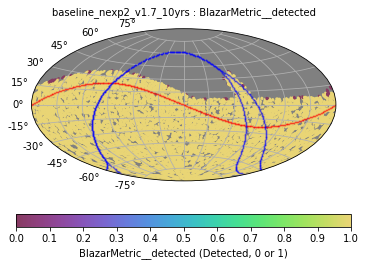

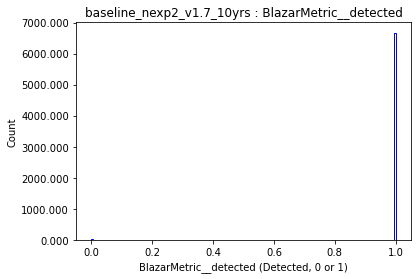

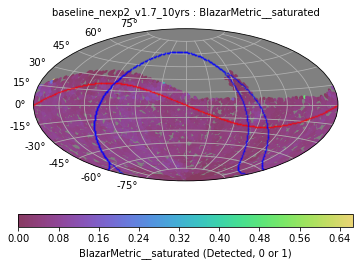

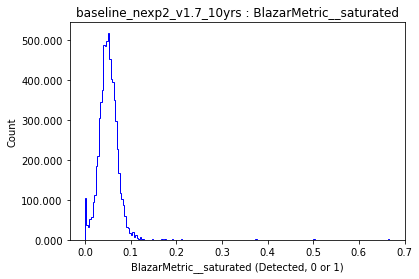

In [12]:


bd = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)



In [13]:
bd

{'baseline_nexp2_v1_7_10yrs_BlazarMetric_USER': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb40df626a0>,
 'BlazarMetric__detected': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb40d532790>,
 'BlazarMetric__saturated': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fb689503d00>}

In [14]:
# We can look at the summary stats. Basically the fraction of objects that got detected as variable, and 
# the mean fraction of saturated points.
bd['BlazarMetric__detected'].summaryValues, bd['BlazarMetric__saturated'].summaryValues

({'Mean': 0.6671}, {'Mean': 0.03377177217633318})

In [15]:
# So, we detected 67% of the objects as variable (not surprising since 
#we scattered them all over the sphere and we don't reach the north). And on average 3% of the 
# observations were saturated. 

In [16]:
# Next steps:  
# * Put in a more realistic light curve function
# * update the detection criteria to be more interesting
# * run on multiple survey simulations to see which strategy is better.